# Fit BAO peak from input correlation function

In [1]:
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging
from cosmoprimo import *

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import split_density, compute_densitySplit_CCF
from densitysplit.pk_model import *
from densitysplit.utils import *
from densitysplit.corr_func import *

# To activate logging
setup_logging()

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
catalog_name = 'AbacusSummit_1Gpc_z1.175'
bias = 1.8

#catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

In [4]:
z = catalog.redshift

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()
f = bg.Omega_m(z)**0.55

## Load correlation function poles

In [5]:
ells = [0]
nells = len(ells)
nsplits = 2

In [6]:
s, xiell_split, cov_split = np.load(output_dir+catalog.name+'_1000_mocks_densitySplit_dg_CCF_monopole_cov.npy', allow_pickle=True)
std_split = np.array_split(np.array(np.array_split(np.diag(cov_split)**0.5, nells)), nsplits, axis=1)

### DS2 only

In [7]:
split = 1

xiell = xiell_split[split]
cov = extract_subcovmatrix(s, cov_split, ells, nsplits, split_extract=split)
std = np.array_split(np.diag(cov)**0.5, nells)

In [8]:
mocks_results = np.load(output_dir+catalog.name+'_1000_mocks_2PCF.npy', allow_pickle=True)
ells = [0]
nells = len(ells)

xiell, cov = get_poles(mocks_results, ells)
std = np.array_split(np.diag(cov)**0.5, nells)

## Set power spectrum model

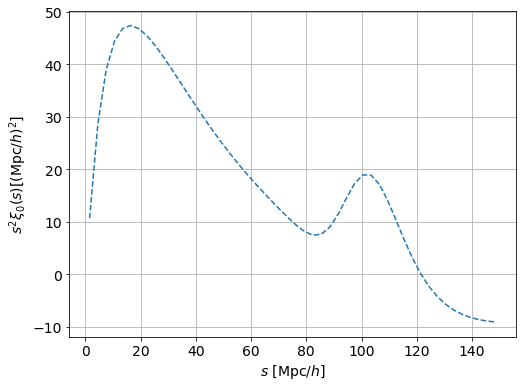

In [9]:
pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
pk_model.set_pk_model()
default_params = {'f': 0., 'b': 2., 'alpha_par': 1., 'alpha_perp': 1., 'sigma_par': 5., 'sigma_perp': 5., 'sigma_s': 0.}
pk_model.set_default_params(**default_params)
pk_model.plot_model()

## Fit model to data

In [10]:
# Remove small scales (linear model not valid at small scales)
s_lower_limit = 50 # Mpc/h

# initialize parameters
broadband_coeffs = np.tile([0., 0., 0.], nells)
params_init = {'b': 2., 'alpha_par': 1., 'sigma_par': 5., 'broadband_coeffs': broadband_coeffs}

pk_model.fit(fit_params_init=params_init, s_lower_limit=s_lower_limit)

if hasattr(pk_model, 'broadband_coeffs'):
    model = pk_model.model(pk_model_params=pk_model.model_popt_dict, broadband_coeffs=pk_model.broadband_coeffs)
else:
    model = pk_model.model(pk_model_params=pk_model.model_popt_dict)

Optimal parameters:
{'b': 1.8018972836413507, 'alpha_par': 1.007775120462425, 'sigma_par': 4.832409291723025, 'broadband_coeffs': array([ 3.21168765e-02,  5.97615811e-03, -4.75640531e-05])}

Covariance matrix:
[[ 4.31143727e-02  9.13088386e-04  2.81669622e-01 -2.10977478e+00
   2.61543712e-02 -7.05013836e-05]
 [ 9.13088386e-04  1.05252662e-03  8.15840494e-03 -1.82156183e-02
   5.45331037e-04 -2.49765425e-06]
 [ 2.81669622e-01  8.15840494e-03  3.32593271e+00 -1.35812631e+01
   1.66197200e-01 -4.25737761e-04]
 [-2.10977478e+00 -1.82156183e-02 -1.35812631e+01  1.84190704e+02
  -3.30731721e+00  1.39129005e-02]
 [ 2.61543712e-02  5.45331037e-04  1.66197200e-01 -3.30731721e+00
   7.09980720e-02 -3.39261527e-04]
 [-7.05013836e-05 -2.49765425e-06 -4.25737761e-04  1.39129005e-02
  -3.39261527e-04  1.78806863e-06]]

Sigmas:
[2.07640007e-01 3.24426667e-02 1.82371399e+00 1.35716876e+01
 2.66454634e-01 1.33718683e-03]


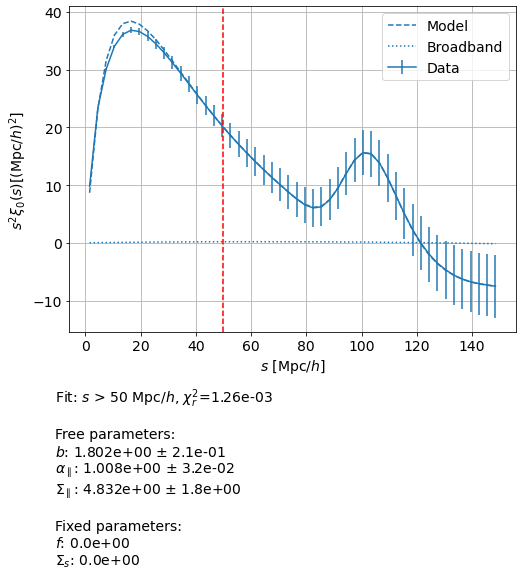

In [11]:
pk_model.plot_model(plot_data=True, show_info=True, show_broadband=True)
plt.show()

### Plot reduced $\chi^2$ as a function of a given parameter ($\alpha_{iso}$ or $\Sigma_{iso}$)

In [13]:
pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
pk_model.set_pk_model()
pk_model.set_default_params(**default_params)

In [31]:
alphas = np.linspace(0.8, 1.2, 30)
#sigmas = np.linspace(0, 10, 30)
pk_model.set_s_lower_limit(50)

def compute_chi2(alpha, bao_peak=True):
    pk_model.set_default_params(alpha_par=alpha)
    # initialize parameters
    params_init = {'b': 2., 'sigma_par': 5., 'broadband_coeffs': broadband_coeffs}
    pk_model.fit(fit_params_init=params_init, s_lower_limit=s_lower_limit, print_output=False, bao_peak=bao_peak)
    return pk_model.chi_square(reduced=False)

chi2 = np.array([compute_chi2(alpha, bao_peak=False) for alpha in alphas])
#chi2_bao_peak = np.array([compute_chi2(alpha) for alpha in alphas])

/feynman/work/dphp/adematti/cosmodesiconda/20220419-1.0.0/conda/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [27]:
min_chi2 = np.min(chi2_bao_peak)

In [28]:
import scipy.stats
conf_int = [scipy.stats.chi2.cdf(s**2, 1) for s in [1, 2, 3]]

In [29]:
chi_squared = [scipy.stats.chi2.ppf(ci, 1) for ci in conf_int]

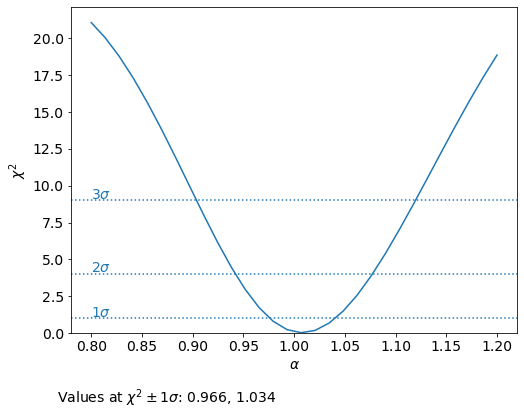

In [30]:
plt.plot(alphas, chi2, label='Without BAO peak', color='C1')
#plt.plot(alphas, chi2_bao_peak, label='With BAO peak', color='C0')
plt.axhline(min_chi2+chi_squared[0], linestyle='dotted', color='C0')
plt.axhline(min_chi2+chi_squared[1], linestyle='dotted', color='C0')
plt.axhline(min_chi2+chi_squared[2], linestyle='dotted', color='C0')
plt.text(0.8, min_chi2+chi_squared[0]+0.1, r'1$\sigma$', color='C0')
plt.text(0.8, min_chi2+chi_squared[1]+0.1, r'2$\sigma$', color='C0')
plt.text(0.8, min_chi2+chi_squared[2]+0.1, r'3$\sigma$', color='C0')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\chi^2$')
plt.ylim(bottom=0)
#plt.legend()

a, b = np.argwhere(np.diff(np.sign(chi2_bao_peak - (min_chi2+chi_squared[0])))).flatten()
plt.suptitle(r'Values at $\chi^2 \pm 1\sigma$: {:.3f}, {:.3f}'.format(alphas[a], alphas[b]),
             ha='left', x=0.1, y=0, size=14)
plt.show()

In [34]:
pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
pk_model.set_pk_model()
pk_model.set_default_params(**default_params)

In [35]:
sigmas = np.linspace(0, 10, 30)
pk_model.set_s_lower_limit(50)

def compute_chi2(sigma, bao_peak=True):
    pk_model.set_default_params(sigma_par=sigma)
    # initialize parameters
    params_init = {'b': 2., 'alpha_par': 1., 'broadband_coeffs': broadband_coeffs}
    pk_model.fit(fit_params_init=params_init, s_lower_limit=s_lower_limit, print_output=False, bao_peak=bao_peak)
    return pk_model.chi_square(reduced=False)

#chi2 = np.array([compute_chi2(sigma, bao_peak=False) for sigma in sigmas])
chi2_bao_peak = np.array([compute_chi2(sigma) for sigma in sigmas])

In [36]:
min_chi2 = np.min(chi2_bao_peak)

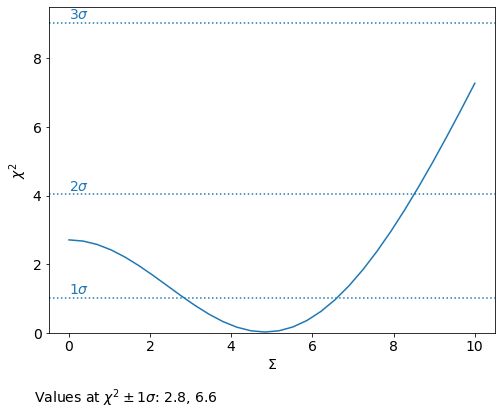

In [39]:
#plt.plot(sigmas, chi2, label='Without BAO peak', color='C1')
plt.plot(sigmas, chi2_bao_peak, label='With BAO peak', color='C0')
plt.axhline(min_chi2+chi_squared[0], linestyle='dotted', color='C0')
plt.axhline(min_chi2+chi_squared[1], linestyle='dotted', color='C0')
plt.axhline(min_chi2+chi_squared[2], linestyle='dotted', color='C0')
plt.text(0., min_chi2+chi_squared[0]+0.1, r'1$\sigma$', color='C0')
plt.text(0., min_chi2+chi_squared[1]+0.1, r'2$\sigma$', color='C0')
plt.text(0., min_chi2+chi_squared[2]+0.1, r'3$\sigma$', color='C0')
plt.xlabel(r'$\Sigma$')
plt.ylabel(r'$\chi^2$')
plt.ylim(bottom=0)
#plt.legend()

a, b = np.argwhere(np.diff(np.sign(chi2_bao_peak - (min_chi2+chi_squared[0])))).flatten()
plt.suptitle(r'Values at $\chi^2 \pm 1\sigma$: {:.1f}, {:.1f}'.format(sigmas[a], sigmas[b]),
             ha='left', x=0.1, y=0, size=14)
plt.show()

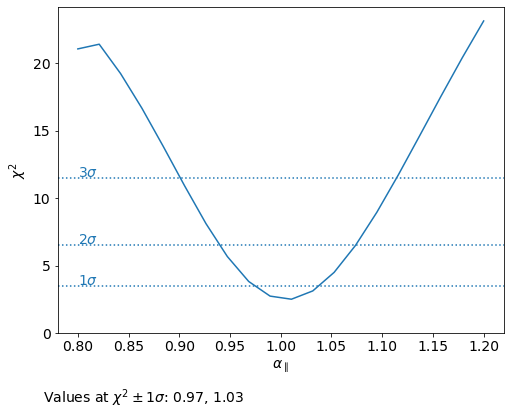

In [14]:
alphas = np.linspace(0.8, 1.2, 20)
pk_model.set_s_lower_limit(50)
free_params_init = {'b': 2., 'sigma_par': 5., 'broadband_coeffs': broadband_coeffs}

alpha_chi2_bao_peak = plot_likelihood(pk_model_test, param_name='alpha_par', param_values=alphas, free_params_init=free_params_init, s_lower_limit=s_lower_limit, without_peak=False)

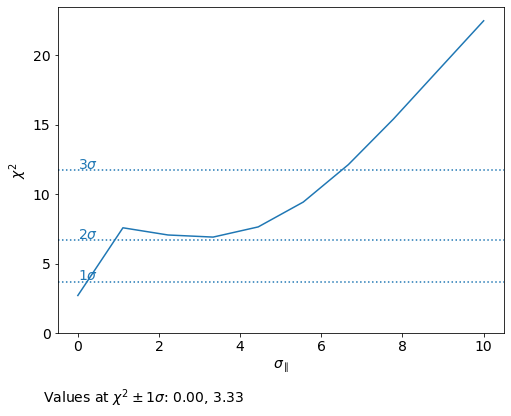

In [ ]:
pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
pk_model.set_pk_model()
pk_model.set_default_params(**default_params)

sigmas = np.linspace(0, 10, 30)
pk_model.set_s_lower_limit(50)
free_params_init = {'b': 2., 'sigma_par': 5., 'broadband_coeffs': broadband_coeffs}

sigma_chi2_bao_peak = plot_likelihood(pk_model, param_name='sigma_par', param_values=sigmas, free_params_init=free_params_init, s_lower_limit=s_lower_limit, without_peak=False)

In [21]:
np.abs(chi2_bao_peak-(min_chi2+chi_squared[0]))

array([7.55132082, 6.93553927, 6.26095389, 5.53871199, 4.78258734,
       4.0086633 , 3.23482584, 2.47999512, 1.76310865, 1.10202078,
       0.51254918, 0.00785393, 0.40180784, 0.70905266, 0.90919354,
       1.        , 0.98148317, 0.85565548, 0.62628894, 0.29857893,
       0.12120697, 0.62603324, 1.20832349, 1.86010801, 2.57310443,
       3.33876585, 4.14834608, 4.99301081, 5.86397812, 6.75264243])